# Library Import and Functions

# Summary Stats for New Genes and Transcripts


### - Figure S2

### - Total number of transcripts and genes across CPM threshold

### - Figure 4

### - Figure 5 & S1

### - Figure 3

### - Figure 2

### - Figure 6

### - Figure S3

### - Figure 7

### - Memes for figures

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [7]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

original_ref = original_ref.loc[~original_ref["chr"].str.startswith("ERCC-")]

## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes_02-04-2023_UPDATED.tsv", sep="\t")

## Brain disease genes
brain_disease_gene_ids = pd.read_csv("../../../references/bernardo/brain_disease_genes_only_IDs.tsv", sep="\t")
brain_disease_annotations = pd.read_csv("../../../references/bernardo/brain_disease_genes_with_disease.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])

ref = ref.loc[~ref["chr"].str.startswith("ERCC-")]

ref = parse_df_columns(ref, is_ref=False)

ref_transcripts = ref.loc[ref["type"] == "transcript"].copy()

# - Figure S2

In [8]:
## Fix column names in counts matrix

df = pd.read_csv("../../../data/bernardo/raw/ad_vs_ct_pilot_study_february_2023_GRCh38-107_discovery/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [9]:
## Calculate total counts and fix gene id
df["total_counts"] = df[df.filter(regex='count').columns].sum(axis=1)

In [10]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [11]:
## Drop ERCCs
df = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [12]:
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [13]:
df = df.merge(ref_transcripts[["gene_id", "transcript_id", "chr"]], on=["gene_id", "transcript_id"], how="inner")

In [14]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [15]:
## Drop new mitochondrial transcripts/genes
df_novel_genes = df_novel_genes.loc[df_novel_genes["chr"] != "MT"].copy()
df_novel_transcripts = df_novel_transcripts.loc[df_novel_transcripts["chr"] != "MT"].copy()

In [16]:
## Filter novel genes and transcripts, one only total CPM > 1, other each CPM > 1

df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

# Figures 5 & S1

In [17]:
## Create list o disease relevant novel transcripts for three stringency thresholds
novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [18]:
## Drop any duplicates
novel_relevant_median.drop_duplicates(inplace=True)

In [19]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [20]:
## Calculate relative transcript abundance
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)

In [21]:
## Annotate novel transcripts on relative abundance table
novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [22]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [23]:
## Drop duplicates
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()

In [24]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [25]:
## Create a dataframe to properly store the data
novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

In [26]:
## Drop index
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)

In [27]:
novel_relevant_median_words_df.shape[0]

49

In [28]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (median CPM > 1): 49


In [29]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [30]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [31]:
## Generate wordclouds
word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1900, height=600).generate(word_list_disease_median)

In [32]:
novel_relevant_median_words_df

,word_count,gene_name
0,9.0,AASS
1,17.0,ACBD6
2,40.0,ALDH1A1
3,39.0,ALG3
4,2.0,APRT
5,3.0,ATG7
6,9.0,B4GALT7
7,19.0,BAX
8,16.0,BCS1L
9,12.0,C1QA


In [33]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = (19, 6)
#rcParams.update({'font.size': 6})
#rcParams['axes.linewidth'] = 1

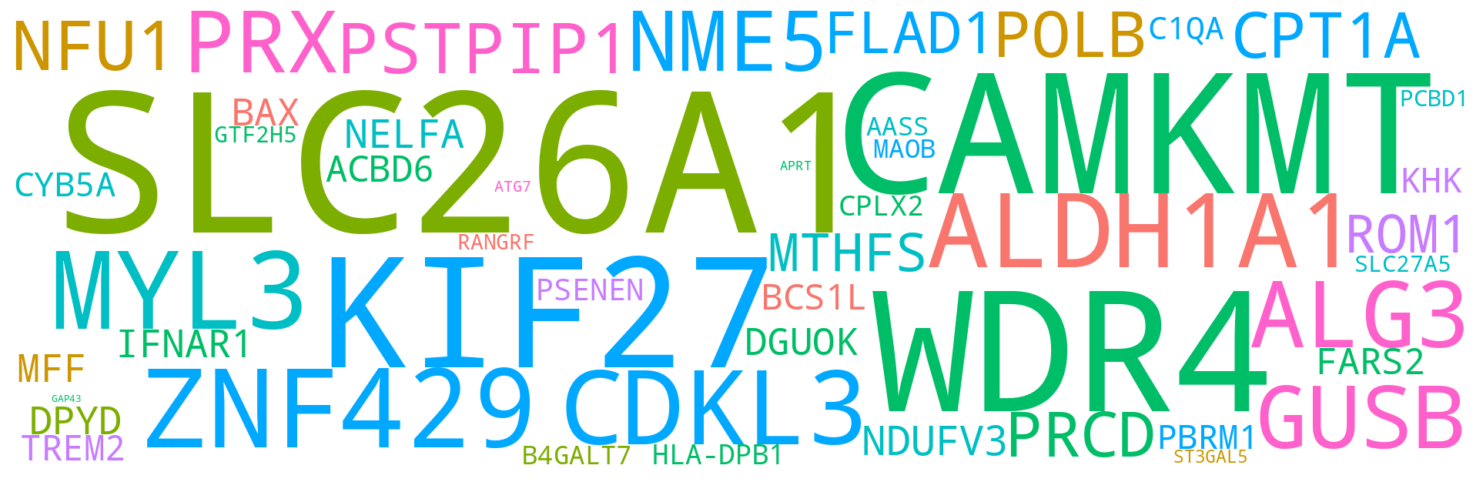

In [34]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/word_cloud_disease_median.png',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/word_cloud_disease_median.svg',
            dpi=1200, transparent=True, bbox_inches="tight")

plt.show()

# - Figure 3

In [35]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [36]:
## Make reference only including protein coding transcripts with a defined CDS
orig_ref_cds = original_ref.loc[original_ref["type"]=="CDS"].copy()
orig_ref_cds = parse_df_columns(orig_ref_cds, is_ref=True, is_transcript=True, is_prot=True)

orig_ref_cds = orig_ref_cds.loc[orig_ref_cds["transcript_biotype"] == "protein_coding"].copy()

In [37]:
ref_cds = orig_ref_cds.loc[~orig_ref_cds["protein_id"].isna()].copy()

ref_cds = ref_cds[["transcript_id", "protein_id"]].copy().drop_duplicates()

In [38]:
## Create dataframes for AD and med relevant genes, drop Mitochondria
df_med_relevant = df.merge(disease_relevant_genes, on="gene_id", how="inner")
df_med_relevant = df_med_relevant.loc[df_med_relevant["chr"] != "MT"].copy()

df_brain_relevant = df_med_relevant.merge(brain_disease_gene_ids["gene_id"], on="gene_id", how="inner")

df_ad = df.merge(ad_names, on="gene_id", how="inner")
df_ad = df_ad.loc[df_ad["chr"] != "MT"].copy()

In [39]:
## Only keep protein coding transcripts in expression matrix, adding protein_ids
df_prot_coding_ccds = df.merge(ref_cds[["transcript_id", "protein_id"]],
                                  how="inner", on="transcript_id").drop_duplicates()

In [40]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_genes_all_median = []
list_genes_proteins_median = []
list_genes_med_relevant_median = []
list_genes_med_relevant_proteins_median = []
list_brain_relevant_median = []
list_brain_relevant_proteins_median = []
list_genes_ad_median = []
list_genes_ad_proteins_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    df_gene_multiple_all = df.loc[df["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_prot = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_med = df_med_relevant.loc[df_med_relevant["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_med_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot["transcript_id"].isin(df_med_relevant["transcript_id"])].copy()
    df_gene_multiple_brain = df_brain_relevant.loc[df_brain_relevant["median_CPM"] >= cpm_thresh].copy()
    df_gene_multiple_brain_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot["transcript_id"].isin(df_brain_relevant["transcript_id"])].copy()
    df_gene_multiple_ad = df_ad.loc[df_ad["median_CPM"] > cpm_thresh].copy()
    df_gene_multiple_ad_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot["transcript_id"].isin(df_gene_multiple_ad["transcript_id"])].copy()

    
    df_gene_multiple_prot = df_gene_multiple_prot.loc[~df_gene_multiple_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_prot = df_gene_multiple_prot.loc[df_gene_multiple_prot.duplicated(subset=["gene_id"], keep=False)].copy()
    df_gene_multiple_med_prot = df_gene_multiple_med_prot.loc[~df_gene_multiple_med_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_med_prot = df_gene_multiple_med_prot.loc[df_gene_multiple_med_prot.duplicated(subset=["gene_id"], keep=False)].copy()
    df_gene_multiple_brain_prot = df_gene_multiple_brain_prot.loc[~df_gene_multiple_brain_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_brain_prot = df_gene_multiple_brain_prot.loc[df_gene_multiple_brain_prot.duplicated(subset=["gene_id"], keep=False)].copy()
    df_gene_multiple_ad_prot = df_gene_multiple_ad_prot.loc[~df_gene_multiple_ad_prot.duplicated(subset=["protein_id"], keep=False)].copy()
    df_gene_multiple_ad_prot = df_gene_multiple_ad_prot.loc[df_gene_multiple_ad_prot.duplicated(subset=["gene_id"], keep=False)].copy()

    
    num_genes_multiple_isoforms = df_gene_multiple_all.loc[df_gene_multiple_all.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_genes_multiple_prot = df_gene_multiple_prot["gene_id"].nunique()
    num_genes_multiple_med_relevant = df_gene_multiple_med.loc[df_gene_multiple_med.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_med_genes_multiple_prot = df_gene_multiple_med_prot["gene_id"].nunique()
    num_genes_multiple_brain_relevant = df_gene_multiple_brain.loc[df_gene_multiple_brain.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_brain_genes_multiple_prot = df_gene_multiple_brain_prot["gene_id"].nunique()
    num_genes_multiple_ad = df_gene_multiple_ad.loc[df_gene_multiple_ad.duplicated(subset="gene_id", keep=False)]["gene_id"].nunique()
    num_ad_genes_multiple_prot = df_gene_multiple_ad_prot["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_genes_all_median.append(num_genes_multiple_isoforms)
    list_genes_proteins_median.append(num_genes_multiple_prot)
    list_genes_med_relevant_median.append(num_genes_multiple_med_relevant)
    list_genes_med_relevant_proteins_median.append(num_med_genes_multiple_prot)
    list_brain_relevant_median.append(num_genes_multiple_brain_relevant)
    list_brain_relevant_proteins_median.append(num_brain_genes_multiple_prot)
    list_genes_ad_median.append(num_genes_multiple_ad)
    list_genes_ad_proteins_median.append(num_ad_genes_multiple_prot)

In [79]:
## Create CPM 1 Threhold multiple isoform filter
df_multiple_iso = df.loc[df["median_CPM"] > 1].copy()
df_multiple_iso = df_multiple_iso.loc[df_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_multiple_iso = df_multiple_iso["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_avg = pd.DataFrame()
df_num_isoforms_avg["Number of gene bodies"] = df_numbers_multiple_iso.value_counts()
df_num_isoforms_avg["Number of transcripts"] = df_numbers_multiple_iso.value_counts().index
df_num_isoforms_avg["Category"] = "All transcripts"

## Group 7+ transcripts
df_num_isoforms_seven = df_num_isoforms_avg.loc[df_num_isoforms_avg["Number of transcripts"] >= 7].copy()
df_num_isoforms_seven = df_num_isoforms_seven.groupby("Category").sum()
df_num_isoforms_seven["Number of transcripts"] = "7+"
df_num_isoforms_seven.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_avg = df_num_isoforms_avg.loc[df_num_isoforms_avg["Number of transcripts"] < 7].copy()
df_num_isoforms_avg["Number of transcripts"] = df_num_isoforms_avg["Number of transcripts"].astype(str)
df_num_isoforms_avg = pd.concat([df_num_isoforms_avg, df_num_isoforms_seven])


In [80]:
## Create CPM 1 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()

df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset=["gene_id"], keep=False)].copy()


## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_gene_mutiple_prot["gene_id"].value_counts()

## Get numbers of genes with multiple CPM > 1 protein coding isoforms for both filters
df_num_isoforms_prot_avg = pd.DataFrame()
df_num_isoforms_prot_avg["Number of gene bodies"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_avg["Number of transcripts"] = df_numbers_prot_multiple_isoforms_median.value_counts().index
df_num_isoforms_prot_avg["Category"] = "Transcripts with different protein coding sequence"

## Group 7+ transcripts
df_num_isoforms_prot_seven = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] >= 7].copy()
df_num_isoforms_prot_seven = df_num_isoforms_prot_seven.groupby("Category").sum()
df_num_isoforms_prot_seven["Number of transcripts"] = "7+"
df_num_isoforms_prot_seven.reset_index(inplace=True)


## Get separate other transcripts
df_num_isoforms_prot_avg = df_num_isoforms_prot_avg.loc[df_num_isoforms_prot_avg["Number of transcripts"] < 7].copy()
df_num_isoforms_prot_avg["Number of transcripts"] = df_num_isoforms_prot_avg["Number of transcripts"].astype(str)
df_num_isoforms_prot_avg = pd.concat([df_num_isoforms_prot_avg, df_num_isoforms_prot_seven])


In [81]:
df_number_isoforms_per_gene = pd.concat([df_num_isoforms_avg, df_num_isoforms_prot_avg])

In [87]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = (7.5, 3.5)
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

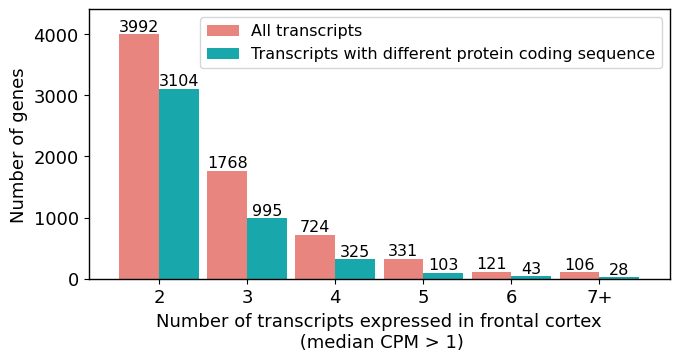

In [94]:
## Make stacked barplot

ax = sns.barplot(data=df_number_isoforms_per_gene, x="Number of transcripts", y="Number of gene bodies",
                 hue="Category", dodge=True, palette=[ggplot2_colors[0], ggplot2_colors[4]], width=0.9)

ax.bar_label(ax.containers[0], fontsize=11.5)
ax.bar_label(ax.containers[1], fontsize=11.5)

ax.set(ylim=(0, 4400), xlim=(-0.8, 5.8))
plt.ylabel("Number of genes")
plt.xlabel("Number of transcripts expressed in frontal cortex\n (median CPM > 1)")
plt.legend(loc="upper right", fontsize=11.5)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/quantify_genes_with_multiple_isoforms.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/quantify_genes_with_multiple_isoforms.svg', dpi=1200, transparent=True, bbox_inches="tight")

In [95]:
## Create annotation for poster children genes
poster_children_names = ["PSEN1", "APP", "MAPT", "BIN1", "CLU"]

In [96]:
## Create CPM 1 Threhold multiple isoform filter

df_prot_avg_multiple_iso = df_prot_coding_ccds.loc[df_prot_coding_ccds["median_CPM"] > 1].copy()

df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[~df_prot_avg_multiple_iso.duplicated(subset=["protein_id"], keep=False)].copy()
df_gene_mutiple_prot = df_prot_avg_multiple_iso.loc[df_prot_avg_multiple_iso.duplicated(subset=["gene_id"], keep=False)].copy()

## Add gene name
df_gene_mutiple_prot = df_gene_mutiple_prot.merge(orig_ref[["gene_id", "gene_name"]],
                                                  how="inner", on="gene_id").drop_duplicates()


## Get number of genes with multiple isoforms
df_ad_prot = df_gene_mutiple_prot.loc[df_gene_mutiple_prot["gene_name"].isin(poster_children_names)]["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')
df_ad_prot["Category"] = "Transcripts with different protein coding sequence"

In [97]:
## Create CPM 1 Threhold multiple isoform filter
df_multiple_iso_ad = df.loc[df["median_CPM"] > 1].copy()
df_multiple_iso_ad = df_multiple_iso_ad.loc[df_multiple_iso_ad.duplicated(subset="gene_id", keep=False)]


## Add gene name
df_multiple_iso_ad = df_multiple_iso_ad.merge(orig_ref[["gene_id", "gene_name"]],
                                                  how="inner", on="gene_id").drop_duplicates()

## Get number of genes with multiple isoforms
df_multiple_iso_ad = df_multiple_iso_ad.loc[df_multiple_iso_ad["gene_name"].isin(poster_children_names)]["gene_name"].value_counts().rename_axis('gene_name').reset_index(name='Number of transcripts')
df_multiple_iso_ad["Category"] = "All transcripts"

In [98]:
df_final = pd.concat([df_ad_prot, df_multiple_iso_ad])

In [121]:
df_psen1 = pd.DataFrame(data={"gene_name": ["PSEN1"], "Number of transcripts": [1], 
                        "Category": ["Transcripts with different protein coding sequence"]})

df_final = pd.concat([df_final, df_psen1])

In [125]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = (7.5, 4)
rcParams.update({'font.size': 13})
rcParams['axes.linewidth'] = 1

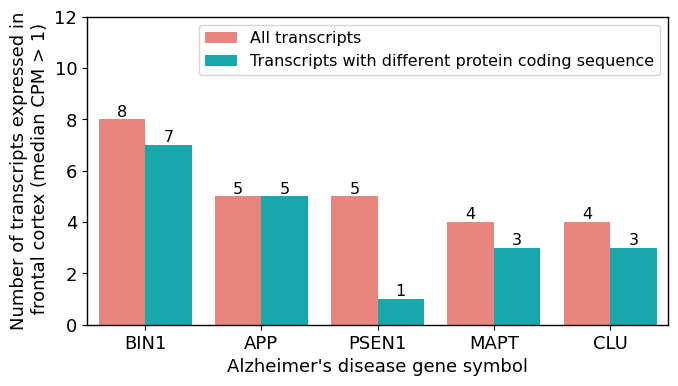

In [126]:
## Make stacked barplot

ax = sns.barplot(data=df_final, x="gene_name", y="Number of transcripts",
                 hue="Category", dodge=True, palette=[ggplot2_colors[0], ggplot2_colors[4]], 
                hue_order=["All transcripts", "Transcripts with different protein coding sequence"],
                order=["BIN1", "APP", "PSEN1", "MAPT", "CLU"])

ax.bar_label(ax.containers[0], fontsize=11.5)
ax.bar_label(ax.containers[1], fontsize=11.5)

ax.set(ylim=(0, 12), xlim=(-0.5, 4.5))

plt.xlabel("Alzheimer's disease gene symbol")
plt.ylabel("Number of transcripts expressed in\n frontal cortex (median CPM > 1)")
plt.legend(loc="upper right", fontsize=11.5)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/AD_genes_with_multiple_isoforms.png', dpi=1200, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/graduate_showcase_poster/AD_genes_with_multiple_isoforms.svg', dpi=1200, transparent=True, bbox_inches="tight")